In [1]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator5 import *
from matrix_helper import *
import matplotlib.pyplot as plt
import pandas as pd
dob = dobbellogger()

In [3]:
cali = calibrate_rot_bias(dob, 3, 1, 100, 2, 125)

Leg de dobbelsteen met nummer  1  boven
Wacht 1 secondes
Logging data for 3s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
Wacht 1 secondes
Logging data for 3s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
Wacht 1 secondes
Logging data for 3s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  4  boven
Wacht 1 secondes
Logging data for 3s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  5  boven
Wacht 1 secondes
Logging data for 3s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  6  boven
Wacht 1 secondes
Logging data for 3s
Done! The data is located in self.datadf
[[-0.80444447 -0.01893291  0.61839876 -0.99970971]
 [-0.01893291  0.75789121  0.99970971 -0.6296691 ]
 [ 0.61839876  0.99970971  0.80444447 -0.01893291]
 [-0.99970971 -0.6296691  -0.01893291 -0.75789121]]


In [4]:
std_cali = cali_std(dob, 3, 100, 2, 125)
gyro_std = std_cali['gyro stds']
acc_std = std_cali['acc stds']

Leg de dobbelsteen stil
Logging data for 3s
Done! The data is located in self.datadf


In [5]:
dob.connect()
dob.log(5, 400, 4, 500)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [6]:
data = remove_nan(data)
data = rotate_remove_bias(data, cali)

In [7]:
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 2495.797904191617
x_acc -0.01624346697171802
y_acc -0.0005394829308893443
z_acc -0.9679753254833873
x_gyro -0.003089188267827211
y_gyro 0.001365814544844178
z_gyro -0.0016861222047788475


In [8]:
data.head()

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,-0.013598,0.001094,-0.967599,-0.050022,0.102993,-0.112999
1,32.0,-0.014777,-0.001183,-0.964558,-0.471481,-0.141351,-0.012255
2,35.0,-0.017851,-0.000308,-0.966308,0.179303,-0.017412,-0.174542
3,38.0,-0.018052,-0.005327,-0.964143,-0.141534,0.042161,-0.161295
4,39.0,-0.020545,-0.003384,-0.968273,-0.182879,0.167514,0.168137


In [9]:
y11 = np.array([np.mean(data['x_acc'][0:10]), np.mean(data['y_acc'][0:10]), np.mean(data['z_acc'][0:10])])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.array([1, 0, 0]) #np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [10]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11_rot = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
v11 = np.array([0,0,0])
p11 = np.array([0,0,0])

In [11]:
Q_gyro = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])
Q_pv_std = 0.0001
Q_pv = Q_pv_std * np.eye(6)
Q = np.vstack([np.hstack([Q_pv, np.zeros((6, 3))]), np.hstack([np.zeros((3, 6)), Q_gyro])])

small_R = 100 * np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

R_pzv_std = 0.0001
R_pzv = R_pzv_std * np.eye(4)
large_R = np.vstack([np.hstack([R_pzv, np.zeros((4, 3))]), np.hstack([np.zeros((3, 4)), small_R])])

Ppvstd = 0
P11 = np.vstack([np.hstack([Ppvstd * np.eye(6), np.zeros((6, 4))]), np.hstack([np.zeros((4, 6)), P11_rot])])

#P11 = np.vstack([np.zeros((6,10)), np.hstack([np.zeros((4, 6)), P11_rot])])

In [12]:
print(P11)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

In [13]:
zv_data = zv_checker(data, 5, 0.05)
print(len(zv_data))
count = 0
for bool in zv_data['zero velocity']:
    if bool:
        count += 1
print(count)
print(list(zv_data['zero velocity']))

2004
1929
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [44]:
xtmin1tmin1 = np.concatenate([p11, v11, q11])
Ptmin1tmin1 = P11

x_list = [xtmin1tmin1]
epsilon_list = []
ygnrot_list = []
yab_list = []

K_list = []
P_list = []

an_list = []

for i in range(1, len(zv_data['timestamp'])):
    dt = (zv_data['timestamp'][i] - zv_data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([zv_data['x_gyro'][i], zv_data['y_gyro'][i], zv_data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    ptmin1tmin1 = xtmin1tmin1[:3]
    vtmin1tmin1 = xtmin1tmin1[3:6]
    qtmin1tmin1 = xtmin1tmin1[6:]

    yat_b = np.array([zv_data['x_acc'][i], zv_data['y_acc'][i], zv_data['z_acc'][i]])
    yat_n = rotate_vector(gn, quaternion_conjugate(np.reshape(qtmin1tmin1, 4)))
    ygnrot_list.append(yat_n)
    yab_list.append(yat_b)
    
    an = rotate_vector(yat_b, np.reshape(qtmin1tmin1, 4)) - gn
    an_list.append(an)
    
    pttmin1 = ptmin1tmin1 + dt * vtmin1tmin1 + 0.5 * an * 9.81 * dt ** 2
    vttmin1 = vtmin1tmin1 + dt * an * 9.81
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    xttmin1 = np.concatenate([pttmin1, vttmin1, qttmin1])

    Ftmin1 = calculate_F(xttmin1, omega, yat_b * 9.81, dt)
    Gtmin1 = calculate_G(xttmin1, dt)
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    P_list.append(Ptmin1tmin1)
    if zv_data['zero velocity'][i]:
        H = calculate_large_H(xttmin1)
        S = np.matmul(np.matmul(H, Pttmin1), H.T) + large_R
        K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
        yateps_rot = yat_b / np.linalg.norm(yat_b)
        yattmin1_rot = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
        epsilon_rot = yateps_rot - yattmin1_rot
        ypzv_est = np.array([pttmin1[2], *vttmin1])
        ypzv_mea = np.zeros(4)
        epsilon_pos = np.reshape(ypzv_mea - ypzv_est, (4, 1))
        epsilon = np.vstack([epsilon_pos, np.reshape(epsilon_rot, (3, 1))])
        x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)
    else:
        H = calculate_small_H(xttmin1)
        S = np.matmul(np.matmul(H, Pttmin1), H.T) + small_R
        K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
        
        K_list.append(K)
        
        yateps = yat_b / np.linalg.norm(yat_b)
        yattmin1 = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
        epsilon = np.reshape(yateps - yattmin1, (3, 1))
        x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)

    epsilon_list.append(epsilon)

    Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    x_tt_measure = np.reshape(x_tt_measure, 10)
    x_tt = np.concatenate([x_tt_measure[:6], x_tt_measure[6:] / np.linalg.norm(x_tt_measure[6:])])
    
    Ptmin1tmin1 = Ptt
    xtmin1tmin1 = x_tt
    x_list.append(x_tt)

x_array = np.reshape(np.concatenate(x_list), (len(x_list), 10))
results = pd.DataFrame(x_array, columns=['px', 'py', 'pz', 'vx', 'vy', 'vz', 'q0', 'q1', 'q2', 'q3'])
results.head(1000)

,px,py,pz,vx,vy,vz,q0,q1,q2,q3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000509,0.999990,-0.000002,-0.004354
1,-0.000146,0.000012,-0.000178,-0.009106,0.000722,-0.011143,-0.000398,0.999988,0.000002,-0.004819
2,-0.000174,0.000014,-0.000213,-0.009373,0.000706,-0.012131,-0.000403,0.999988,0.000007,-0.004828
3,-0.000202,0.000016,-0.000251,-0.009630,0.000840,-0.013183,-0.000404,0.999988,0.000011,-0.004836
4,-0.000212,0.000017,-0.000265,-0.009740,0.000865,-0.013492,-0.000403,0.999988,0.000010,-0.004836
...,...,...,...,...,...,...,...,...,...,...
995,0.003546,0.000043,-0.129765,-0.016049,0.000743,-0.258938,-0.000295,0.999972,-0.000069,-0.007541
996,0.003538,0.000043,-0.129931,-0.015958,0.000688,-0.259131,-0.000296,0.999972,-0.000073,-0.007541
997,0.003546,0.000043,-0.129838,-0.015958,0.000745,-0.258965,-0.000301,0.999972,-0.000073,-0.007541
998,0.003538,0.000043,-0.130003,-0.016009,0.000756,-0.259044,-0.000300,0.999971,-0.000074,-0.007544


In [45]:
for k in K_list[:10]:
    print(k[4,:])

[ 1.15457466e-02 -1.55781973e+00  7.72767471e-04]
[ 2.22150882e-04 -2.50685958e-03 -8.79029042e-07]
[ 8.76162380e-07 -3.33863385e-06 -7.54773044e-09]
[ 1.56635527e-09  8.24138862e-09 -2.22702003e-11]
[-1.13061384e-09  1.01515621e-08  5.97727315e-12]
[ 9.00299065e-09  9.16858774e-08 -1.56247725e-10]
[ 4.33477369e-09  9.09268913e-08 -1.04471605e-10]
[ 1.53108352e-09  4.07788661e-08 -4.25681210e-11]
[ 4.44256814e-09  1.71704721e-08 -5.95418832e-11]
[-5.12738123e-09  4.03584383e-08  3.13755851e-11]


In [46]:
from IPython.display import display, Math, Latex
def array_to_latex(arr):
    latex_str = r'\begin{bmatrix}'
    for row in arr:
        row_str = ' & '.join(map(str, row))
        latex_str += row_str + r'\\'
    latex_str += r'\end{bmatrix}'
    return latex_str


In [47]:
gnrots = np.reshape(np.concatenate(ygnrot_list), (int(len(ygnrot_list)), 3))
for i in range(3):
    print(np.mean(gnrots[:,i]))

-0.01442050352895354
-0.0005552926778334761
-0.9998942729476061


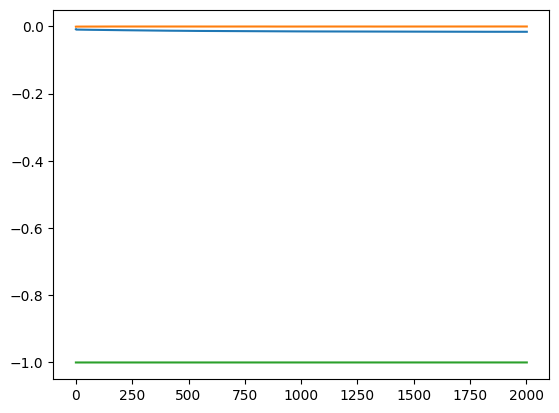

In [48]:
plt.plot(gnrots[:,0])
plt.plot(gnrots[:,1])
plt.plot(gnrots[:,2])
plt.show()

In [49]:
yabs = np.reshape(np.concatenate(yab_list), (int(len(yab_list)), 3))
for i in range(3):
    print(np.mean(yabs[:,i]))

-0.016244787658446298
-0.0005402985268515108
-0.967975513359955


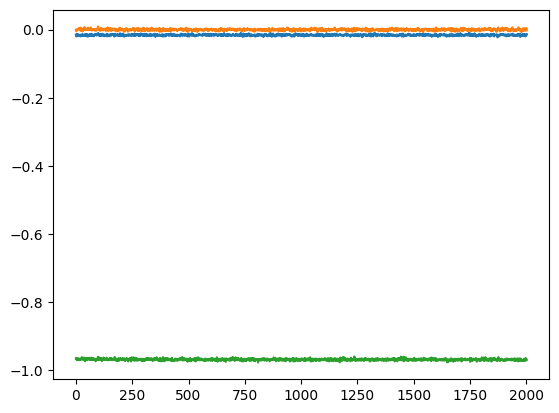

In [50]:
plt.plot(yabs[:,0])
plt.plot(yabs[:,1])
plt.plot(yabs[:,2])
plt.show()

In [51]:
print(np.linalg.norm(np.mean(yabs, axis=0)))

0.9681119664135108


In [52]:
plot_x = []
plot_y = []
plot_z = []

for x, timestamp in zip(x_list, data['timestamp']):
    euler = quaternion_to_euler(x[6:]) * 180 / np.pi
    plot_x.append(euler[0])
    plot_y.append(euler[1])
    plot_z.append(euler[2])

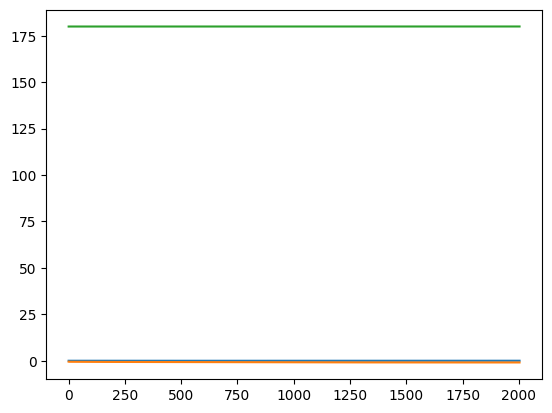

In [53]:
plt.plot(plot_x)
plt.plot(plot_y)
plt.plot(plot_z)

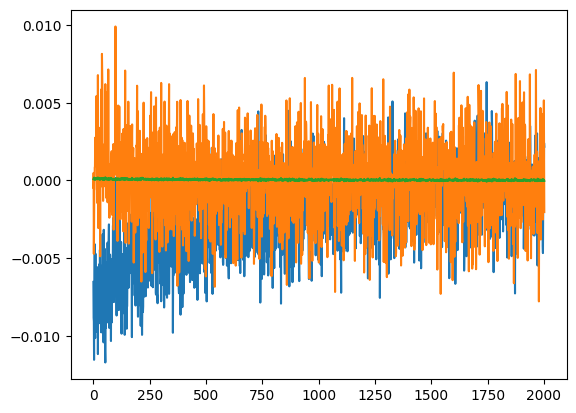

In [54]:
epsilon_rot = []
for e in epsilon_list:
    epsilon_rot.append(e[-3:, 0])
    
epsilons = np.concatenate(epsilon_rot)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

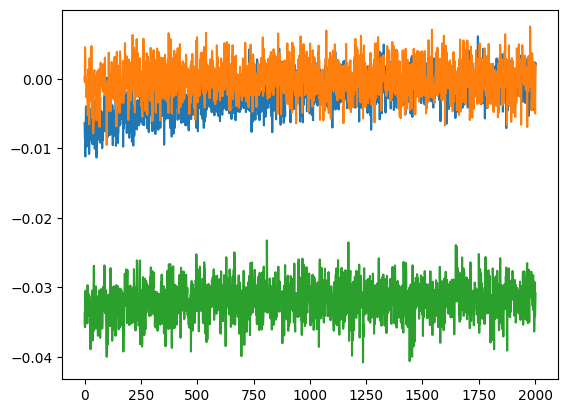

In [55]:
yans = np.reshape(np.concatenate(an_list), (len(an_list), 3))
plt.plot(yans[:,0])
plt.plot(yans[:,1])
plt.plot(yans[:,2])
plt.show()

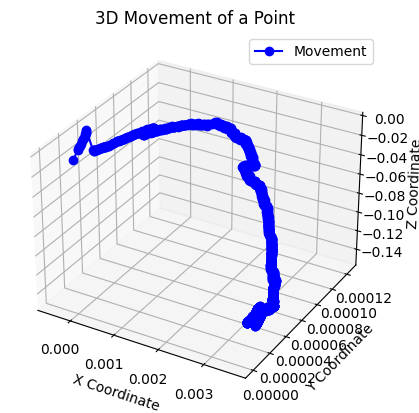

In [56]:
positions = x_array[:,:3]
# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(positions[:,0], positions[:,1], positions[:,2], marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()

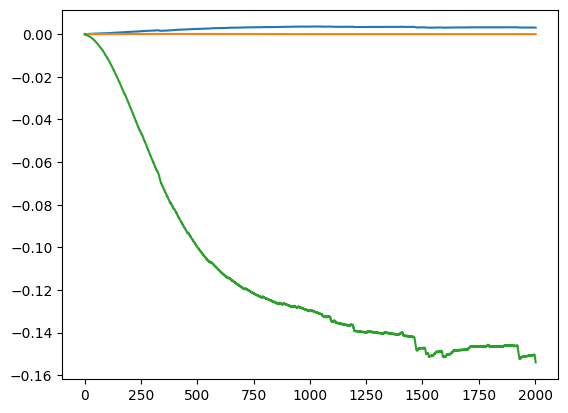

In [57]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])
plt.plot(positions[:,2])
plt.show()

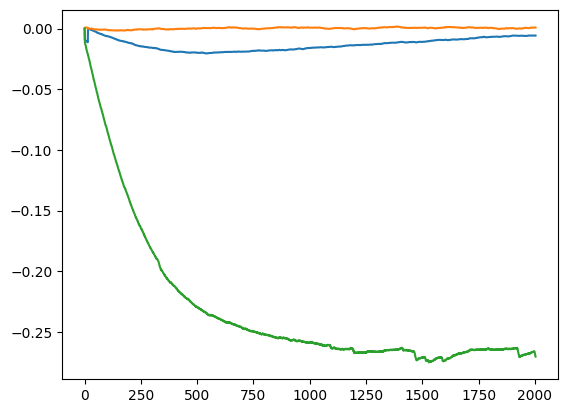

In [58]:
velocities = x_array[:,3:6]
plt.plot(velocities[:, 0])
plt.plot(velocities[:, 1])
plt.plot(velocities[:, 2])
plt.show()

In [165]:
dob.disconnect()

we are disconnected!
